Sample synthetic data:
        date product_id  historical_sales  promotion  holiday  day_of_week  \
0 2020-01-01  Product_A         95.717738          0        0            2   
1 2020-01-02  Product_A         78.704347          0        0            3   
2 2020-01-03  Product_A        113.104590          0        0            4   
3 2020-01-04  Product_A        102.351423          0        0            5   
4 2020-01-05  Product_A        109.564676          0        0            6   

   month  year  
0      1  2020  
1      1  2020  
2      1  2020  
3      1  2020  
4      1  2020  

Model Evaluation:
MAE: 14.96
MSE: 328.11
RMSE: 18.11

Feature Importance:
promotion               0.262765
month                   0.200285
product_id_Product_B    0.146275
product_id_Product_C    0.123624
year                    0.123032
holiday                 0.096378
day_of_week             0.047641
dtype: float64


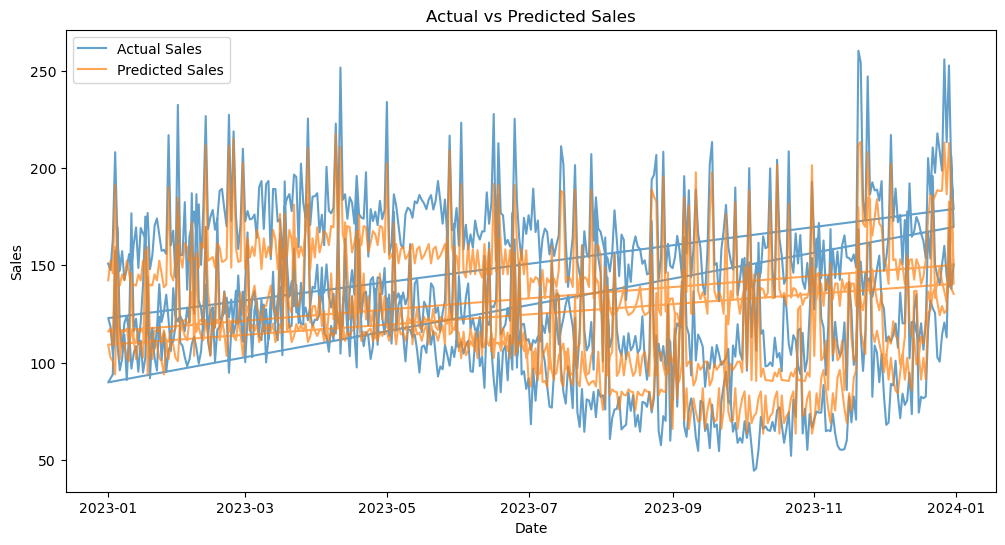

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate synthetic data
def generate_synthetic_data(start_date='2020-01-01', end_date='2023-12-31'):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    products = ['Product_A', 'Product_B', 'Product_C']
    data = pd.DataFrame()
    
    for product in products:
        product_df = pd.DataFrame({'date': dates})
        product_df['product_id'] = product
        num_days = len(dates)
        
        # Base parameters
        if product == 'Product_A':
            base = 100
            trend = 0.05
            season_amp = 20
        elif product == 'Product_B':
            base = 80
            trend = 0.03
            season_amp = 15
        else:
            base = 120
            trend = -0.02
            season_amp = 25
        
        # Create components
        t = np.arange(num_days)
        trend_component = trend * t
        seasonality = season_amp * np.sin(2 * np.pi * t / 365)
        
        # Promotions (random 10% days)
        promotion = np.random.choice([0, 1], size=num_days, p=[0.9, 0.1])
        promotion_effect = 50 * promotion
        
        # Holidays (Nov-Dec 20-31)
        holiday = (product_df['date'].dt.month.isin([11, 12])) & \
                  (product_df['date'].dt.day.isin(range(20, 31)))
        holiday_effect = 30 * holiday.astype(int)
        
        # Random noise
        noise = np.random.normal(0, 10, num_days)
        
        # Combine components
        sales = base + trend_component + seasonality + promotion_effect + holiday_effect + noise
        product_df['historical_sales'] = sales.clip(lower=0)  # Ensure non-negative sales
        
        # Add features
        product_df['promotion'] = promotion
        product_df['holiday'] = holiday.astype(int)
        product_df['day_of_week'] = product_df['date'].dt.dayofweek
        product_df['month'] = product_df['date'].dt.month
        product_df['year'] = product_df['date'].dt.year
        
        data = pd.concat([data, product_df], ignore_index=True)
    
    return data

# Generate and inspect data
synthetic_data = generate_synthetic_data()
print("Sample synthetic data:")
print(synthetic_data.head())

# Feature engineering
data = synthetic_data.copy()
data = pd.get_dummies(data, columns=['product_id'], drop_first=True)

# Split data (time-based split)
train = data[data['date'] < '2023-01-01']
test = data[data['date'] >= '2023-01-01']

# Prepare features
features = ['promotion', 'holiday', 'day_of_week', 'month', 'year',
            'product_id_Product_B', 'product_id_Product_C']
X_train = train[features]
y_train = train['historical_sales']
X_test = test[features]
y_test = test['historical_sales']

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate model
print("\nModel Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, predictions):.2f}")
print(f"MSE: {mean_squared_error(y_test, predictions):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, predictions)):.2f}")

# Feature importance
importance = pd.Series(model.feature_importances_, index=features)
importance = importance.sort_values(ascending=False)
print("\nFeature Importance:")
print(importance)

# Visualize predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(test['date'], y_test, label='Actual Sales', alpha=0.7)
plt.plot(test['date'], predictions, label='Predicted Sales', alpha=0.7)
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()